<center><img src="../images/logo.png"/></center>

SynthGauge is a Python library providing a framework in which to evaluate synthetically generated data.

This notebook provides a basic example workflow for using SynthGauge. For further details on the functionality of the package, see the docs (LINK??).

In [1]:
import synthgauge as sg

%matplotlib inline

Throughout we will be using toy datasets created using the `make_classification()` function in `sklearn`.

In [2]:
real_data = sg.datasets.make_blood_types_df(noise=0, seed=101)
synth_data = sg.datasets.make_blood_types_df(noise=1, seed=101)

print(real_data.head())
print("\n")
print(synth_data.head())

    age  height  weight hair_colour eye_colour blood_type
0  39.0   180.0    76.0       Black      Green          A
1  48.0   178.0    82.0       Black      Brown          B
2  35.0   168.0    68.0       Black      Brown          B
3  39.0   172.0    82.0       Brown       Blue          O
4  61.0   161.0    84.0       Brown       Blue          B


    age  height  weight hair_colour eye_colour blood_type
0  35.0   169.0    79.0       Black      Brown          A
1  58.0   184.0    86.0       Brown      Brown          B
2  25.0   166.0    65.0       Black      Brown          B
3  37.0   165.0    81.0      Blonde      Brown          A
4  53.0   164.0    87.0      Blonde      Brown          B


SynthGauge revolves around a central `Evaluator` object that must first be instantiated.

In [3]:
evaluator = sg.Evaluator(real_data, synth_data)

We can then use in-built methods to see summary statistics of the data.

In [4]:
evaluator.describe_categorical()

,count,unique,most_frequent,freq
blood_type_real,1000,4,O,374
blood_type_synth,1000,4,A,588
eye_colour_real,1000,3,Brown,643
eye_colour_synth,1000,3,Brown,664
hair_colour_real,1000,4,Brown,468
hair_colour_synth,1000,4,Brown,460


In [5]:
evaluator.describe_numeric()

,count,mean,std,min,25%,50%,75%,max
age_real,1000.0,41.792,8.465483,16.0,36.0,41.0,47.0,77.0
age_synth,1000.0,41.477,10.198013,8.0,34.0,41.0,48.0,81.0
height_real,1000.0,173.879,8.704029,149.0,168.0,174.0,180.0,204.0
height_synth,1000.0,173.786,10.733378,144.0,166.0,173.0,181.0,210.0
weight_real,1000.0,78.265,9.952579,47.0,72.0,79.0,85.0,113.0
weight_synth,1000.0,78.424,11.463666,42.0,71.0,79.0,86.0,116.0


# Plotting

The evaluator object has methods to visually compare the real and synthetic data.

The `plot_histograms()` method allows us to look at the univariate distribution of the features.

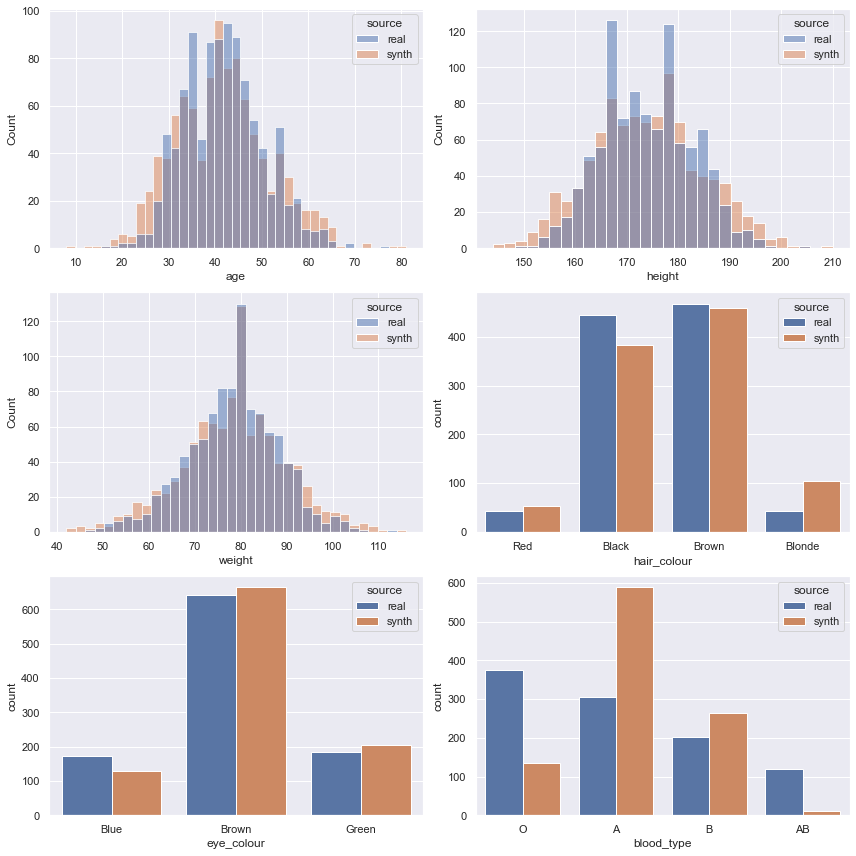

In [6]:
evaluator.plot_histograms(figsize=(12, 12));

`plot_correlation()` lets us look at the relationships between variables. The third plot shows the difference between the correlation scores.

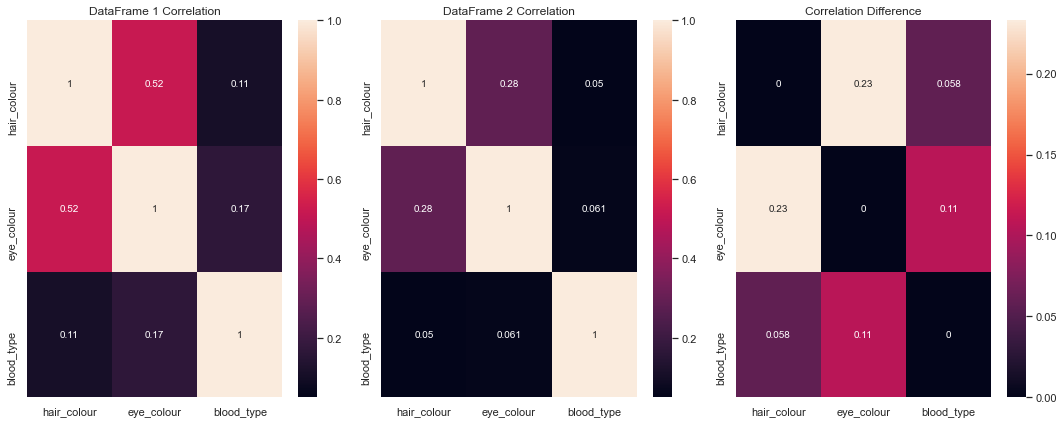

In [7]:
evaluator.plot_correlation(
    feats=["hair_colour", "eye_colour", "blood_type"],
    method="cramers_v",
    figsize=(15, 6),
    figcols=3,
    annot=True,
);

Here we see that the features `hair_colour` and `eye_colour` seem to have the biggest difference between their correlation in the real dataset and in the synthetic dataset. We could use the `plot_crosstab()` method to investigate this further.

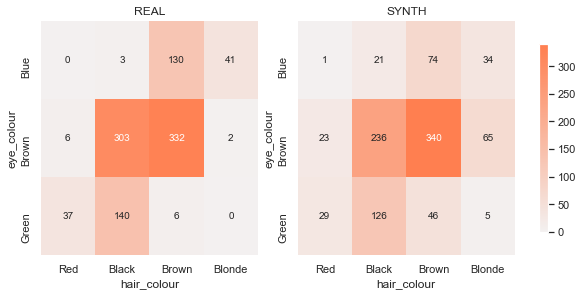

In [8]:
evaluator.plot_crosstab(
    "hair_colour",
    "eye_colour",
    figsize=(8, 4),
    cmap="light:coral",
    annot=True,
    fmt="d",
);

# Metrics

We can also evaluate the synthetic data using metrics. These first need to be added to the evaluator before running the `evaluate()` method. To add these metrics we use the `add_metric()` method, specifying the metric name, optionally an alias, followed by keyword arguments that will be passed to the metric function.

In [9]:
# univariate distribution comparisons
for feat in ("age", "height", "weight"):
    evaluator.add_metric("wasserstein", alias=f"wass-{feat}", feature=feat)

for feat in ("hair_colour", "eye_colour", "blood_type"):
    short = feat.split("_")[0]
    evaluator.add_metric(
        "jensen_shannon_distance",
        alias=f"jenshan-{short}",
        feature=feat,
        bins=None,
    )

# correlation
evaluator.add_metric("correlation_msd", alias="pearson-msd")
evaluator.add_metric("correlation_msd", alias="cramers-msd", method="cramers_v")

# distinguishability
evaluator.add_metric("propensity_metrics")

evaluator.evaluate(as_df=True)

,value
wass-age,1.329000
wass-height,1.469000
wass-weight,1.147000
jenshan-hair,0.089442
jenshan-eye,0.044969
jenshan-blood,0.281916
pearson-msd,0.021031
cramers-msd,0.022921
propensity_metrics-pmse,0.243833
propensity_metrics-pmse_standardised,-0.815949


More details about the specific metrics can be found in the documentation or by using the help function.

In [10]:
help(sg.metrics.univariate.wasserstein)

Help on function wasserstein in module synthgauge.metrics.univariate:

wasserstein(real, synth, feature, **kwargs)
    The (first) Wasserstein distance.
    
    Also known as the "Earth Mover's" distance, this metric can be
    thought of as calculating the amount of "work" required to move from
    the distribution of the synthetic data to the distribution of the
    real data.
    
    Parameters
    ----------
    real : pandas.DataFrame
        Dataframe containing the real data.
    synth : pandas.DataFrame
        Dataframe containing the synthetic data.
    feature : str
        Feature of the datasets to compare. This must be continuous.
    **kwargs : dict, optional
        Keyword arguments for `scipy.stats.wasserstein_distance`.
    
    Returns
    -------
    float
        The computed distance between the distributions.
    
    See Also
    --------
    scipy.stats.wasserstein_distance
    
    Notes
    -----
    This is a wrapper for `scipy.stats.wasserstein_distance`

It is possible to also add user-defined metrics to the Evaluator object to accommodate specific use cases. The custom_metric() method takes as inputs a name to be displayed in the results table and a function which will be given the real and synthetic datasets as the first and second arguments respectively. Keyword arguments can be specified to pass other parameters to the metric function.

In [11]:
from scipy.stats import skew


def skew_difference(real, synth, feature):
    """Calculate the absolute difference in skew for a feature."""

    real_skew = skew(real[feature])
    synth_skew = skew(synth[feature])

    return abs(real_skew - synth_skew)


evaluator.add_custom_metric("skew-diff-age", skew_difference, feature="age")
evaluator.evaluate(as_df=True)

,value
wass-age,1.329000
wass-height,1.469000
wass-weight,1.147000
jenshan-hair,0.089442
jenshan-eye,0.044969
jenshan-blood,0.281916
pearson-msd,0.021031
cramers-msd,0.022921
propensity_metrics-pmse,0.244250
propensity_metrics-pmse_standardised,-0.635313


# Comparing with another dataset

The functionality of SynthGauge makes it easy to compare different synthetic datasets. It's as simple as creating another evaluator object with the new synthetic datset, running the same plotting methods, and 'copying' the metrics from the first evaluator.

In [12]:
synth_data_comparison = sg.datasets.make_blood_types_df(noise=0.5, seed=101)

comparison_evaluator = sg.Evaluator(real_data, synth_data_comparison)

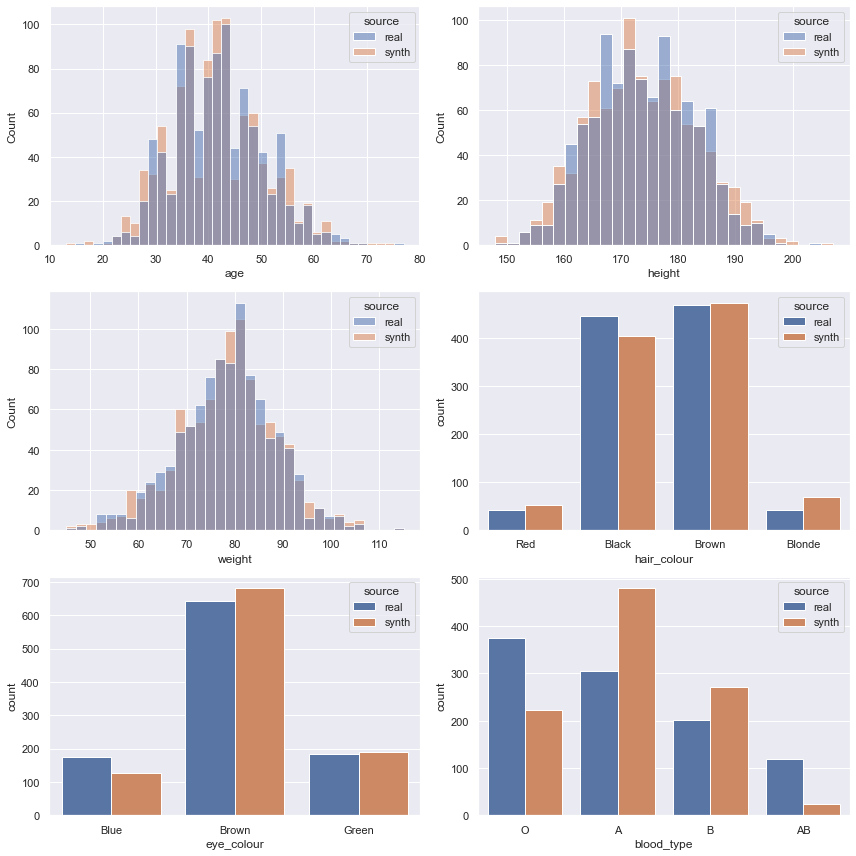

In [13]:
comparison_evaluator.plot_histograms(figsize=(12, 12));

In [14]:
comparison_evaluator.copy_metrics(evaluator)
comparison_evaluator.evaluate(as_df=True)

,value
wass-age,0.412000
wass-height,0.507000
wass-weight,0.344000
jenshan-hair,0.047795
jenshan-eye,0.046605
jenshan-blood,0.198479
pearson-msd,0.002585
cramers-msd,0.004842
propensity_metrics-pmse,0.244583
propensity_metrics-pmse_standardised,0.612337
